In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, roc_curve, average_precision_score
import xgboost as xgb
from bayes_opt import BayesianOptimization
import yaml
import joblib
import os

# XGBoost On The Original Dataset

### XGBoost is a good fit because:
- Robust to Missing Values
- Captures Nonlinear Relationships
- Regularization Prevents Overfitting
- Fast and Scalable

### Data Loading

In [10]:
config_path = os.path.join("..", "configs", "paths.yaml")
with open(config_path, "r") as file:
    config = yaml.safe_load(file)

In [11]:
xg_data_path = config["data_paths"]["xg_processed_data_path"]
xg_data_path_full = os.path.join("..", xg_data_path.replace("\\", "/"))
df = pd.read_csv(xg_data_path_full)
df.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,RainTomorrow,day,month,year,TempDiff,WindSpeedAvg,HumidityDiff,PressureDiff,CloudCoverAvg,WindGustDiff
0,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,...,0,1,12,2008,9.5,22.0,-49.0,-0.6,8.0,22.0
1,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,...,0,2,12,2008,17.7,13.0,-19.0,-2.8,NaN,31.0
2,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,...,0,3,12,2008,12.8,22.5,-8.0,1.1,2.0,23.5
3,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,...,0,4,12,2008,18.8,10.0,-29.0,-4.8,NaN,14.0
4,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,...,0,5,12,2008,14.8,13.5,-49.0,-4.8,7.5,27.5


#### Class Weights

In [12]:
len(df.loc[df['RainTomorrow'] == 0]) / (len(df.loc[df['RainTomorrow'] == 1]))

3.4606769771308468

#### Seperating Data

In [13]:
num_cols = df.select_dtypes(include=['number']).columns.difference(['RainTomorrow'])
cat_cols = df.select_dtypes(include=['object']).columns

#### Split Train and Test Data

In [14]:
X = df.drop('RainTomorrow', axis=1)
for col in cat_cols:
  X[col] = X[col].astype('category') # Change: Assign the converted dtype back to the column
y = df['RainTomorrow']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Build The Model

#### Null Model

In [15]:
y_null_pred = y_train.value_counts()[0]
null_accuracy = (y_null_pred/len(y_train))

print('Null accuracy score: {0:0.4f}'. format(null_accuracy))

Null accuracy score: 0.7755


### XGBoost Model

In [16]:
model = xgb.XGBClassifier(
    eta=0.1,#0.1
    n_estimators=100,#100
    enable_categorical=True,
    scale_pos_weight=3,
    gamma=1,
    max_depth=6,
    min_child_weight=2,#2
    reg_lambda=2,
    reg_alpha=2,#2
    subsample=1,#
    colsample_bytree=0.82#
)
model.fit(X_train, y_train)
print("model score: %.3f" % model.score(X_train, y_train))

model score: 0.852


## Model Evaluation

In [17]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

#### Tain-set Accuracy

In [18]:
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))
print("Confusion Matrix:\n", confusion_matrix(y_train, y_pred_train))
print("Classification Report:\n", classification_report(y_train, y_pred_train))

Training-set accuracy score: 0.8523
Confusion Matrix:
 [[76026 12192]
 [ 4606 20930]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.86      0.90     88218
           1       0.63      0.82      0.71     25536

    accuracy                           0.85    113754
   macro avg       0.79      0.84      0.81    113754
weighted avg       0.87      0.85      0.86    113754



#### Test-set Accuracy

In [19]:
print('model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred_test)))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test))
print("Classification Report:\n", classification_report(y_test, y_pred_test))

model accuracy score: 0.8286
Confusion Matrix:
 [[18685  3413]
 [ 1461  4880]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.85      0.88     22098
           1       0.59      0.77      0.67      6341

    accuracy                           0.83     28439
   macro avg       0.76      0.81      0.78     28439
weighted avg       0.85      0.83      0.84     28439



#### Confusion Matrix

Text(0.5, 1.0, 'Confusion Matrix of XGBoost Model')

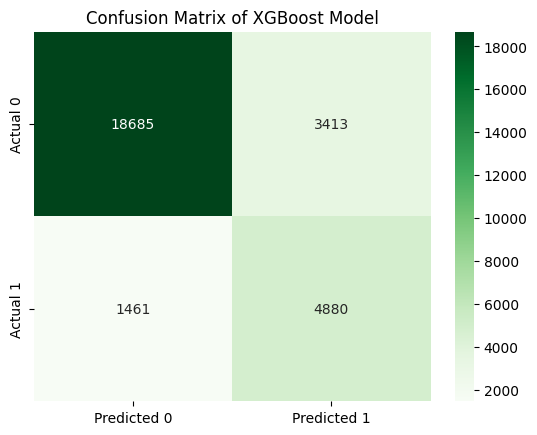

In [20]:
test_cm = confusion_matrix(y_test, y_pred_test)

cm_matrix = pd.DataFrame(
    data=test_cm,
    columns=['Predicted 0', 'Predicted 1'],
    index=['Actual 0', 'Actual 1']
)

sns.heatmap(cm_matrix, annot=True, cmap='Greens', fmt='d')
plt.title("Confusion Matrix of XGBoost Model")

In [21]:
TP = test_cm[1, 1]
TN = test_cm[0, 0]
FP = test_cm[0, 1]
FN = test_cm[1, 0]

#### ROC Curve

In [22]:
y_pred_prob = model.predict_proba(X_test)

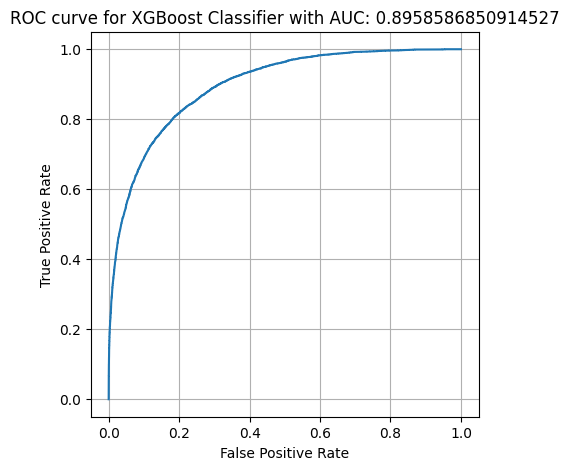

In [23]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:, 1])
ROC_AUC = roc_auc_score(y_test, y_pred_prob[:, 1])

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr)
plt.title(f"ROC curve for XGBoost Classifier with AUC: {ROC_AUC}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid()
plt.show()

with AUC ≈ 0.896, your model:

- Can correctly distinguish between rain and no rain ~90% of the time.

- Has strong discriminative power.

- Suggests that your classifier’s predicted probabilities are informative.

#### Classification error

In [24]:
classification_error = (FP + FN) / float(TP + TN + FP + FN)
print('Classification error : {0:0.4f}'.format(classification_error))

Classification error : 0.1714


#### Precision


In [25]:
p = TP / float(TP + FP)
print('Precision : {0:0.4f}'.format(p))

Precision : 0.5884


#### Recall

In [26]:
recall = TP / float(TP + FN)
print('Recall or Sensitivity : {0:0.4f}'.format(recall))

Recall or Sensitivity : 0.7696


In rain prediction, `recall` is more important than `precision`, because missing a rain event (false negative) is worse than a false alarm.

#### Tune Decision Threshold

In [27]:
y_probs = y_pred_prob[:, 1]
thresh = 0.53
y_pred_new = (y_probs >= thresh).astype(int)

In [28]:
print(confusion_matrix(y_test, y_pred_new))
print(classification_report(y_test, y_pred_new))

[[19053  3045]
 [ 1588  4753]]
              precision    recall  f1-score   support

           0       0.92      0.86      0.89     22098
           1       0.61      0.75      0.67      6341

    accuracy                           0.84     28439
   macro avg       0.77      0.81      0.78     28439
weighted avg       0.85      0.84      0.84     28439



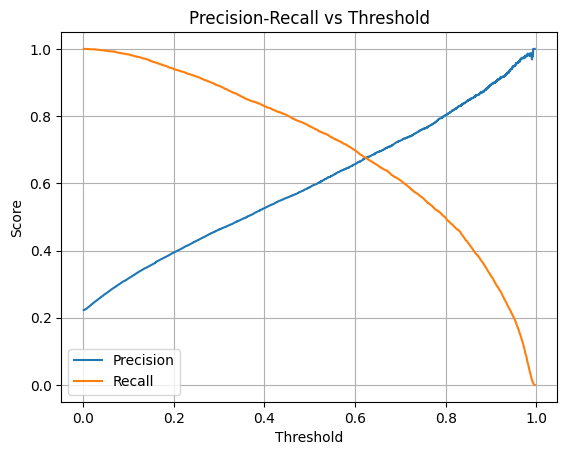

In [29]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall vs Threshold")
plt.legend()
plt.grid(True)
plt.show()


`0.53` is a sweet spot keeping `recall` above `75%` and `precision` above `60%`

#### Feature Importance Analysis

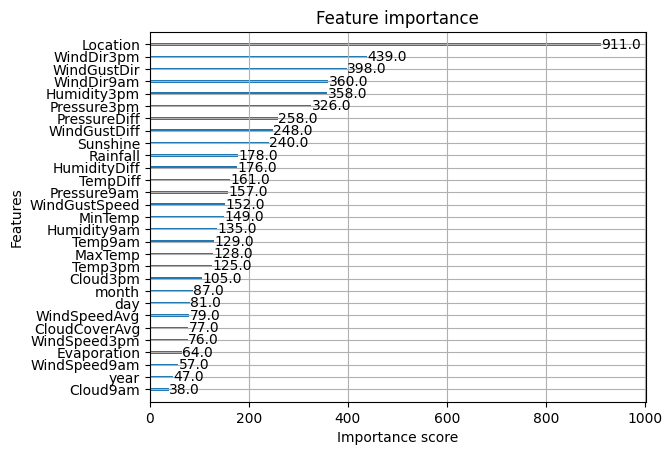

In [30]:
from xgboost import plot_importance

plot_importance(model)
plt.show()

 ### Bayesian Optimization

In [32]:
# Convert to DMatrix format for xgboost (better for bayesian optimization)
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dval = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

def xgb_eval(learning_rate, max_depth, min_child_weight, subsample, colsample_bytree, gamma, reg_alpha, reg_lambda, scale_pos_weight):
    """
    XGBoost evaluation function for Bayesian optimization
    """
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'aucpr',  # AUC-PR is better for imbalanced rain prediction
        'learning_rate': max(min(learning_rate, 0.3), 0.01),  # Clipped between 0.01-0.3
        'max_depth': int(max_depth),
        'min_child_weight': int(min_child_weight),
        'subsample': max(min(subsample, 1), 0.5),
        'colsample_bytree': max(min(colsample_bytree, 1), 0.5),
        'gamma': max(gamma, 0),
        'reg_alpha': max(reg_alpha, 0),
        'reg_lambda': max(reg_lambda, 0),
        'scale_pos_weight': max(scale_pos_weight, 1),
        'tree_method': 'hist',
        'seed': 42
    }

    # Train with early stopping
    model = xgb.XGBClassifier(**params, enable_categorical=True,)
    model.fit(
        X_train, y_train,

        eval_set=[(X_test, y_test)],
        verbose=0
    )

    # Get predictions and calculate multiple metrics
    y_pred = model.predict_proba(X_test)[:, 1]
    auc_pr = average_precision_score(y_test, y_pred)

    # You can return other metrics if needed
    return auc_pr

# Define the parameter bounds
pbounds = {
    'learning_rate': (0.01, 0.3),
    'max_depth': (3, 10),
    'min_child_weight': (1, 10),
    'subsample': (0.5, 1),
    'colsample_bytree': (0.5, 1),
    'gamma': (0, 5),
    'reg_alpha': (0, 10),
    'reg_lambda': (0, 10),
    'scale_pos_weight': (3, 4)  
}

# Initialize Bayesian optimizer
optimizer = BayesianOptimization(
    f=xgb_eval,
    pbounds=pbounds,
    random_state=42,
    verbose=2
)

# Run optimization
optimizer.maximize(
    init_points=10,  
    n_iter=30,       
)

# Print the best parameters found
print("Best parameters found:")
print(optimizer.max)

best_params = optimizer.max['params']

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | reg_alpha | reg_la... | scale_... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
| 1         | 0.7516    | 0.6873    | 4.754     | 0.2223    | 7.191     | 2.404     | 1.56      | 0.5808    | 3.866     | 0.8006    |
| 2         | 0.7406    | 0.854     | 0.1029    | 0.2913    | 8.827     | 2.911     | 1.818     | 1.834     | 3.304     | 0.7624    |
| 3         | 0.7361    | 0.716     | 1.456     | 0.1874    | 3.976     | 3.629     | 3.664     | 4.561     | 3.785     | 0.5998    |
| 4         | 0.7309    | 0.7571    | 2.962     | 0.02347   | 7.253     | 2.535     | 0.6505    | 9.489     | 3.966     | 0.9042    |
| 5         | 0.7525    | 0.6523    | 0.4884    | 0.2084    | 6.081     | 2.098     | 4.952     | 0.3439    | 3.909     | 0.6294    |
| 6         | 0.7568    | 0.8313    | 1.559     | 0.1608    | 

In [33]:
# ensuring that max_depth and min_child_weight are integers
best_params['max_depth'] = int(best_params['max_depth'])
best_params['min_child_weight'] = int(best_params['min_child_weight'])

# 
final_model = xgb.XGBClassifier(
    objective='binary:logistic',
    enable_categorical=True,
    **best_params
)

final_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=0
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=np.float64(0.8172779598859746), device=None,
              early_stopping_rounds=None, enable_categorical=True,
              eval_metric=None, feature_types=None, feature_weights=None,
              gamma=np.float64(1.2738712393427747), grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=np.float64(0.27315565712485607), max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [34]:
# Evaluate final model
y_pred_proba = final_model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba >= 0.53).astype(int)  

print("\nFinal Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"AUC-PR: {average_precision_score(y_test, y_pred_proba):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred))
print(f"ROC_AUC Score: {roc_auc_score(y_test, y_pred_prob[:, 1])}")


Final Model Evaluation:
Accuracy: 0.8357
AUC-PR: 0.7579
Precision: 0.6051
Recall: 0.7579
F1 Score: 0.6729
              precision    recall  f1-score   support

           0       0.93      0.86      0.89     22098
           1       0.61      0.76      0.67      6341

    accuracy                           0.84     28439
   macro avg       0.77      0.81      0.78     28439
weighted avg       0.85      0.84      0.84     28439

ROC_AUC Score: 0.8958586850914527


> The final model accuracy is `0.8357` and null accuracy is `0.7755`, so our model is doing a very good job in predicting the class labels.

In [35]:
model_path = config["artifacts_paths"]["xg_model_path"]
xg_model_path_full = os.path.join("..", model_path.replace("\\", "/"))

joblib.dump(final_model, xg_model_path_full)

['..\\models/xgboost_model.pkl']